In [23]:
import random
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import models
from sklearn.model_selection import KFold
import os
import copy
from PIL import Image
import pandas as pd
from skimage import io
from matplotlib.pyplot import figure
import matplotlib

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


set this to true if running without the data files and just this notebook itself.

In [25]:
runFromScratch = False

# 1. Federate Averaging

set a new path and create a folder there 

In [26]:
path = '/content/drive/MyDrive/fl_defence'
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

else:
    print('Directory already exist!')

Directory already exist!


create 3 nn model using vgg as the base model and changing its classifer.

In [27]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity,self).__init__()
        
    def forward(self,x):
        return x

def set_fl_models():

    fl_model = models.vgg16(pretrained=True, init_weights=False)
    fl_model.avgpool = Identity()
    fl_model.classifier = nn.Sequential(
        nn.Linear(512, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )

    return fl_model

cifar_model = set_fl_models().cuda()
cifar_model2 = set_fl_models().cuda()
cifar_model3 = set_fl_models().cuda()


loads the cifar dataset and concate train and test to get the entire dataset, this for further seperation in the next cell

In [28]:
batch = 1000
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_transform = transforms.ToTensor()
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True,transform = train_transform)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True,transform = test_transform)

cifar_data = torch.utils.data.ConcatDataset([cifar_train,cifar_test])

Files already downloaded and verified
Files already downloaded and verified


seperates the entire cifar dataset into three seperate portion, which is our partitions for the dataset.

In [29]:
length = int(len(cifar_data)/3)
m1_set,m2_set,m3_set = torch.utils.data.random_split(cifar_data,[length,length,length])

m1_train = torch.utils.data.DataLoader(m1_set, batch_size=batch, shuffle=False)
m1_test = torch.utils.data.DataLoader(m1_set, batch_size=batch, shuffle=False)

m2_train = torch.utils.data.DataLoader(m2_set, batch_size=batch, shuffle=False)
m2_test = torch.utils.data.DataLoader(m2_set, batch_size=batch, shuffle=False)

m3_train = torch.utils.data.DataLoader(m2_set, batch_size=batch, shuffle=False)
m3_test = torch.utils.data.DataLoader(m2_set, batch_size=batch, shuffle=False)

function to train a particular model for 5 epoches

In [30]:
def train_model(model,train_set):
    model.train()
  
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    epoch_loss = 0
    epoch_correct = 0
    for epoch in range(5):  

        train_running_loss = 0.0
        test_running_loss=0.0
        for i, data in enumerate(train_set):

            inputs, labels = data
            inputs, labels  = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()


            train_running_loss += loss.item()
        


        print(f'    epoch: {epoch + 1}, training loss: {train_running_loss/len(train_set)}')
    #torch.save(model.state_dict(), f'{path}/{s}')


val and evaluate functions works tgt to output the evaluated accuracy of the trained model

In [31]:
def val (outputs,labels):
    correct = 0
    for i in range(len(labels)):
        if labels[i] == torch.argmax(outputs[i]):
            correct+=1
        
    return correct/batch*100

In [32]:
def evaluate(model,test_set):
    model.eval()
    total_acc = 0
    for i, data in enumerate(test_set):
            
            inputs, labels = data
            inputs,labels = inputs.cuda(),labels.cuda()

            outputs = model(inputs)
            acc = val(outputs,labels)
            total_acc += acc


    print(f'    Accuracy: {total_acc/len(test_set)}%')

this snippet trians the three models, gets their parameters, average them and evaluate the accuracy at the end of an epoch. This is repeated for 5 epoches in order to achieve a satisfied result.

In [33]:
fl_model = set_fl_models().cuda()
if runFromScratch:
  for i in range(5):
          print(f'Epoch : {i}')
          fl_model = copy.deepcopy(cifar_model)
          print('Training...')
          print('\n')
          print( '  Model 1')
          train_model(cifar_model,m1_train)
          print('\n')
          print( '  Model 2')
          train_model(cifar_model2,m2_train)
          print('\n')
          print( '  Model 3')
          train_model(cifar_model3,m3_train)

          print('\n')
          print('Evaluating...')
       
          print( '  Model 1')
          evaluate(cifar_model,m1_test)
        
          print( '  Model 2')
          evaluate(cifar_model2,m3_test)
     
          print( '  Model 3')
          evaluate(cifar_model2,m3_test)

          m1 = list(cifar_model.parameters())
          m2 = list(cifar_model2.parameters())
          m3 = list(cifar_model3.parameters())
          
     
          z = []
          for i in range (len(m1)):
              sum = torch.add(torch.add(m1[i],m2[i]),m3[i])
              avg = sum/3
              z.append(avg)

          i = 0
          with torch.no_grad():
              for name, param in fl_model.named_parameters():

                  param.copy_(z[i])
                  i+=1
          print('\n\n')

          cifar_model = copy.deepcopy(fl_model)
          cifar_model2 = copy.deepcopy(fl_model)
          cifar_model3 = copy.deepcopy(fl_model)

  torch.save(fl_model.state_dict(), f'{path}/fl_model.pth')

else:
  fl_model.load_state_dict(torch.load(f'{path}/fl_model.pth'))

evaluate the testing set from the three client/partition, using the final fedavg model

In [34]:
evaluate(fl_model,m1_test)
evaluate(fl_model,m2_test)
evaluate(fl_model,m3_test)

    Accuracy: 86.88999999999999%
    Accuracy: 86.50999999999999%
    Accuracy: 86.43499999999999%


# 2. White box/Untargeted/One pixel attack

This portion would be focusing on getting perturbated data using one pixel attack, train the model with the perturbated data to increase the defence of the model on such attacks.

In [35]:
path = '/content/drive/MyDrive/fl_defence/pre_pert_numpy'
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

else:
    print('Directory already exist!')

Directory already exist!


In [36]:
cifar_class = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

creates a new model that copys the parameter of the trained fedavg model

In [37]:
cifar_model = copy.deepcopy(fl_model)

initialize the differential evolution method. We random 400 values of x,y position, e.g 0,10. And 400 values of r,g,b values.

In [38]:
parent_pert = []

parent_x = np.random.uniform(0,32,400)
parent_y = np.random.uniform(0,32,400)
parent_r = np.random.uniform(0,1,400)
parent_g = np.random.uniform(0,1,400)
parent_b = np.random.uniform(0,1,400)

initialize the initial matrix.

In [39]:
for i in range(len(parent_x)):
    
    #append the r,g,b values to individual cells, e.g [0,10] = (25,22,80)
    parent_pert.append((int(parent_x[i]),int(parent_y[i]),parent_r[i],parent_g[i],parent_b[i]))

parent_pert = np.asarray(parent_pert)

#initialize a new matrix that has three channels, one for each color
parent_pert_matrix = np.zeros((3,32,32))

#assign r,g,b values to a particular cell at different color channels. For example, channel 0 for [0,10] = 25, channel 1 for [0,10] = 22 and channel 2 for [0,10] = 80
for i in range (3):
    if i == 0:
        w = 2
    elif i == 1:
        w = 3
    else:
        w = 4
    for j in range (len(parent_pert)):
        parent_pert_matrix [i][int(parent_pert[j][0])][int(parent_pert[j][1])] = parent_pert[j][w]

create a new array called fitness, append the prediction value by changing a particular pixel of the image into the array. Fill up the array for every pixel in the image.

In [40]:
def evaluation(chosen_pert,chosen_img):
    fitness = []
    for i in range (len(chosen_pert)):
        mnist_testset_chosen_t = torch.clone(chosen_img.squeeze()).cuda()
        
        #the chosen x and y coordiante
        temp_x = chosen_pert[i][0]
        temp_y = chosen_pert[i][1]


        #the chosen r,g,b values
        temp_r = chosen_pert[i][2]
        temp_g = chosen_pert[i][3]
        temp_b = chosen_pert[i][4]

        #assign the r,g,b values to designed channel for the x,y coordinates of the copy of the original image
        mnist_testset_chosen_t[0][int(temp_x)][int(temp_y)] = temp_r
        mnist_testset_chosen_t[1][int(temp_x)][int(temp_y)] = temp_g
        mnist_testset_chosen_t[2][int(temp_x)][int(temp_y)] = temp_b

        #predict confidence
        pert_pred = cifar_model(mnist_testset_chosen_t.unsqueeze(0))

        #append into the fitness array,repeat this for all the potential candidates (r,g,b for a particular x,y coordinate)
        fitness.append(pert_pred.squeeze()[2].item())

    return np.asarray(fitness)

the implementation of the differential evolution algorithm. 

In [41]:
def new_gen(parent_pert):
    child_pert = []

    for i in range(400):
        # randomly generate 3 numbers from [0,400], one for each r,g,b values
        R = np.random.choice(400, size=3, replace=False)
        
        #perform calculation for the generation of new candidate
        ui = np.asarray(parent_pert[R[2]]) + 0.5 * (np.asarray(parent_pert[R[0]]) - np.asarray(parent_pert[1]))

        #get the x and y coordinate for the new candidate
        x = np.clip(abs(int(ui[0])),0,32)
        y = np.clip(abs(int(ui[1])),0,32)
        
        #assign r,g,b for the new candidate
        #repeat this for 400 times
        child_pert.append((x,y,ui[2],ui[3],ui[4]))
    return np.asarray(child_pert)

a function that reads data from all the numpy files we've saved. Concatenate all the data and output three arrays, namely all_pert_imgs,all_ori_class and all_per_class that contains data from all the numpy files.


We then save the actual perturbated images into a folder; We also save the name of these images e.g. 0_0.png which stands for perturbated image at index 0 with label of 0 and their corresponding class of 0 into a csv file for future manipulation. An example is given in the second cell of section 3.

In [42]:
def getPertData(numpy_path,csv=False):
    
    files = ['opc0.npy','opc1.npy','opc2.npy','opc3.npy','opc4.npy','opc5.npy','opc6.npy','opc7.npy','opc8.npy','opc9.npy']
    all_pert_imgs = np.zeros((0,3,32,32))
    all_ori_class = np.zeros(0)
    all_pert_class = np.zeros(0)
    for i in range (len(files)):
        with open(f'{numpy_path}/{files[i]}', 'rb') as f:
            pert_imgs = np.load(f)
            ori_class = np.load(f)
            pert_class = np.load(f)
        all_pert_imgs = np.concatenate((all_pert_imgs,pert_imgs),0)
        all_ori_class = np.concatenate((all_ori_class,ori_class),0)
        all_pert_class = np.concatenate((all_pert_class,pert_class),0)
        
    if csv:
        isExist = os.path.exists('/content/drive/MyDrive/fl_defence/pre_pert_dataset')
        if not isExist:
            os.makedirs('/content/drive/MyDrive/fl_defence/pre_pert_dataset')
            for i in range (len(all_ori_class)):
                img = np.transpose(all_pert_imgs[i],(1,2,0))
                im = Image.fromarray(np.uint8((img)*255))
                im.save(f'/content/drive/MyDrive/fl_defence/pre_pert_dataset/{i}_{int(all_ori_class[i])}.png')

            df = pd.DataFrame({'title':[f'{0}_{int(all_ori_class[0])}.png'],'label':[int(all_ori_class[0])]})
            for i in range (1,len(all_ori_class)):
                dict = {'title':f'{i}_{int(all_ori_class[i])}.png','label':int(all_ori_class[i])}
                df = df.append(dict,ignore_index=True)
            df.to_csv('/content/drive/MyDrive/fl_defence/pre_pert_dataset.csv',index=False)
        else:
            print('Directory already exist!')
        
    return all_pert_imgs,all_ori_class,all_pert_class

The actual differential evolution algorithm that runs for 10 iterations, the algorithm would try to search for the change of r,g,b of a pixel that yields the lowest confidence. 

During each iteration, 400 children candidates is generated, and is compared with their corresponding parents on the confidence produced. Only the one that yields lower/higher (depends on if it is untargeted or targeted) confidence makes it to the next round.

The algorithm is ran over the entire cifar testing set which consist of 10,000 images, and is separated into 10 epochs/segments (most outter loop) to account for any interruption during the attack and save the data for that epoch to prevent setbacks.

The first if else condition checks if the original image is being classified correctly; It would be meaningless to continue if it is wrong in the first place. Thats why the fedavg model had to be trained to yield a satisfactory result prior to this.

And then 10 iterations of differential evolution comparison, the original article's requirement is 100, but due to resource and time contraint, we are only able to do 10.

The iterations can stop ealier if the images is wrongly classified.



In [43]:
all_index = np.arange(10000)

In [44]:
def differential_evolution(current_model,numpy_path):
  if runFromScratch:
    for i in range (10):
      pert_imgs = []
      ori_class = []
      pert_class = []
      count= 0
      #segregates the indexs into 10 segments, 1000 index for each, perturbated data is being saved as a numpy file after every 1000 indexes.
      part_index = all_index[i*1000:i*1000+1000]
      
      # accounts for setbacks
      for index in range(len(part_index)):

          chosen = part_index[index]

          test_img = cifar_test[chosen][0].cuda()
          ori_label = cifar_test[chosen][1]

          #checks for initial classification correctness
          if torch.argmax(current_model(test_img.unsqueeze(0))).item()!=ori_label:
              print(f'Wrong prediction {chosen}')
              print(torch.argmax(current_model(test_img.unsqueeze(0))).item())
              print(ori_label)
              print('\n')
              continue

          for i in range (10):
              # evaluate the initial generation
              p_fitness = evaluation(parent_pert,test_img)
              

              # generate new generation
              children_pert = new_gen(parent_pert)
              

              # evaluate the children generation
              c_fitness = evaluation(children_pert,test_img)
              

              #winner survives
              mask = c_fitness < p_fitness
              parent_pert[mask] = children_pert[mask]
              p_fitness[mask] = c_fitness[mask]
              final_pixel = parent_pert[np.argmin(p_fitness)]

              #initialize the pert_img to be passed into the fedavg model.
              pert_img = torch.clone((test_img).squeeze()).cuda()
              pert_img[0][int(final_pixel[0])][int(final_pixel[1])] = final_pixel[2]
              pert_img[1][int(final_pixel[0])][int(final_pixel[1])] = final_pixel[3]
              pert_img[2][int(final_pixel[0])][int(final_pixel[1])] = final_pixel[4]
              pert_pre = current_model(pert_img.unsqueeze(0))
              

              #breaks loop early if the perturbated image is classified wrongly
              if torch.argmax(current_model(pert_img.unsqueeze(0)))!=ori_label:
                  #save the corresponding data, such as the original class label, perturbated data and perturbated class into corresponding arrays.
                  ori_class.append(ori_label)
                  pert_imgs.append(pert_img.cpu().detach().numpy())
                  pert_class.append(torch.argmax(current_model(pert_img.unsqueeze(0))).item())
                  count+=1
                  break

          print(f'original prediction: {torch.argmax(current_model(test_img.unsqueeze(0))).item()}')
          print(f'pertubated prediction: {torch.argmax(current_model(pert_img.unsqueeze(0))).item()}')
          print(f'total : {count}')
          print(f'no. : {chosen}\n')

    #save the pert_imgs,ori_class and pert_class arrays into numpy files.
    with open(f'{numpy_path}/opc{i}.npy', 'wb') as f:
        np.save(f, pert_imgs)
        np.save(f, ori_class)
        np.save(f, pert_class)


    return getPertData(numpy_path,csv=True)
  else:
      #retrieve the numpy file if not runnning from scratch
      return getPertData(numpy_path,csv=True)


all_pert_imgs_pre,all_ori_class_pre,all_pert_class_pre = differential_evolution(cifar_model,path)

Directory already exist!


the total amount data that is wrong classified using the differential evolution method with just 10 epoches is 5568, that is more than half of the entire testing set.

In [45]:
print(len(all_pert_class_pre))

5568


# 3. White box/Untargeted/One pixel Defence


we would train the model with the perturbated data this time to see if we can raise its defence against such attack

In [46]:
path = '/content/drive/MyDrive/fl_defence/pre_pert_dataset'

we retrieve the data of perturbated image from the csv we save earlier on and perform a test image showing.

     title  label
0  0_0.png      0
1  1_6.png      6
2  2_1.png      1
3  3_1.png      1
4  4_0.png      0
5568


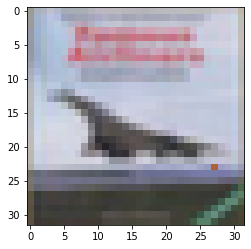

In [47]:
df = pd.read_csv(f'{path}.csv')
print(df.head())
print(len(df))
image = Image.open(f'{path}/0_0.png')
plt.imshow(image)

below is somemore examples of the perturbated data,their original class and perturbated class.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 5568 + 1) instead
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'cat to truck')

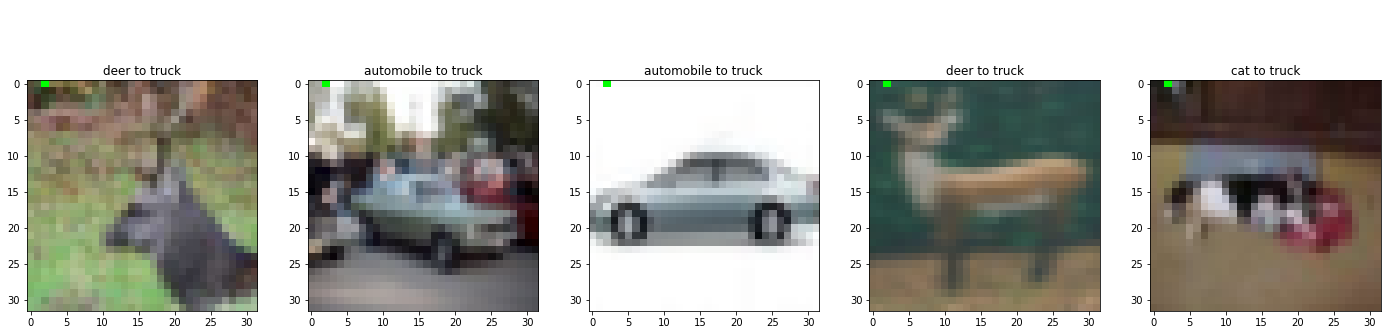

In [48]:
gap = 0.65
r = np.random.random_integers(0,len(all_ori_class_pre),5)
plt.axes([2.4,-1,0.6,0.8])
plt.imshow(np.transpose(all_pert_imgs_pre[r[0]],(1,2,0)),interpolation='nearest')
plt.title(f'{cifar_class[int(all_ori_class_pre[r[0]])]} to {cifar_class[int(all_pert_class_pre[r[0]])]}')

plt.axes([2.4+gap,-1,0.6,0.8])
plt.imshow(np.transpose(all_pert_imgs_pre[r[1]],(1,2,0)),interpolation='nearest')
plt.title(f'{cifar_class[int(all_ori_class_pre[r[1]])]} to {cifar_class[int(all_pert_class_pre[r[1]])]}')


plt.axes([2.4+gap*2,-1,0.6,0.8])
plt.imshow(np.transpose(all_pert_imgs_pre[r[2]],(1,2,0)),interpolation='nearest')
plt.title(f'{cifar_class[int(all_ori_class_pre[r[2]])]} to {cifar_class[int(all_pert_class_pre[r[2]])]}')

plt.axes([2.4+gap*3,-1,0.6,0.8])
plt.imshow(np.transpose(all_pert_imgs_pre[r[3]],(1,2,0)),interpolation='nearest')
plt.title(f'{cifar_class[int(all_ori_class_pre[r[3]])]} to {cifar_class[int(all_pert_class_pre[r[3]])]}')

plt.axes([2.4+gap*4,-1,0.6,0.8])
plt.imshow(np.transpose(all_pert_imgs_pre[r[4]],(1,2,0)),interpolation='nearest')
plt.title(f'{cifar_class[int(all_ori_class_pre[r[4]])]} to {cifar_class[int(all_pert_class_pre[r[4]])]}')

A custom class that retrieve the perturbated images we have saved earlier, works in a similar way to functions that retrieves cifar from the pytorch site.

In [49]:
class PertDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])

        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))
        
        if self.transform:
            image = self.transform(image)
            #y_label = torch.Tensor([y_label])
            
        return (image,y_label)
        

retrieves the data using the class above and perform certain data agumentations. Seperates the perturbated data into training and testing set

In [50]:
pert_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
])

dataset = PertDataset(csv_file = f'{path}.csv' ,root_dir = path,transform = pert_transform)
#seperate perturbated data into training and testing data.
pert_train,pert_test = torch.utils.data.random_split(dataset,[5000,568])


In [51]:
#append the perturbated data into the original cifar training and testing set.
cifar_train_pert = torch.utils.data.ConcatDataset([cifar_train,pert_train])
cifar_test_pert = torch.utils.data.ConcatDataset([cifar_test,pert_test])


train_loader = torch.utils.data.DataLoader(cifar_train_pert, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(cifar_test_pert, batch_size=1000, shuffle=False)

get the original fedavg model

In [52]:
defence_model = copy.deepcopy(fl_model)

train the fedavg model with the new data for 50 epoches or simply retrieve the saved model if not running from scratch

In [53]:
if runFromScratch:
  defence_model.train()
  optimizer = torch.optim.SGD(defence_model.parameters(), lr=0.01, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  graph = []

  epoch_loss = 0
  epoch_correct = 0

  for epoch in range(50):  
      
      train_running_loss = 0.0
      test_running_loss=0.0
      for i, data in enumerate(train_loader):

          inputs, labels = data

          inputs, labels  = inputs.cuda(), labels.cuda()
          
          optimizer.zero_grad()
          
          outputs = defence_model(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          
          optimizer.step()
        
          
          train_running_loss += loss.item()
      graph.append(train_running_loss)
          
          
      print(f'epoch: {epoch + 1}, training loss: {train_running_loss/len(train_loader)}')
  torch.save(cifar_model.state_dict(), '/content/drive/MyDrive/fl_defence/fl_defence_model')
else:
  defence_model.load_state_dict(torch.load('/content/drive/MyDrive/fl_defence/fl_defence_model.pth'))

perform differential evolution algorithm again on the new trained fedavg model.

In [54]:
path = '/content/drive/MyDrive/fl_defence/post_pert_numpy'
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
else:
    print('Directory already exist!')

Directory already exist!


In [55]:
all_pert_imgs_post,all_ori_class_post,all_pert_class_post = differential_evolution(defence_model,path)

Directory already exist!


In [59]:
print(len(all_pert_imgs_post))

2295


get all the original label from the cifar dataset 

In [56]:
ori_label = []
for i in range (len(cifar_test)):
        ori_label.append(cifar_test[i][1])

The final comparison graph.

The total perturbated data decreased from 5568 to 2295. More than a 50% decrease. Also, we can see there is a decrease of perturbated data across all classes excepts for truck. Which strangely spiked up in numbers.

However, all in all, we can conclude that training with the perturbated data using differential evolution method is effective in guarding such attack.

Also, it has good practical use in real world where people might feed a realistic looking image into the model trying to fool the neural network. This can be compared against FGSM method of adversarial attack where the images might require high epsilon to have the model classify the images wrongly, but would also result in a less realistic and practical image. (The code for the FGSM targeted attack is in the other notebook)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


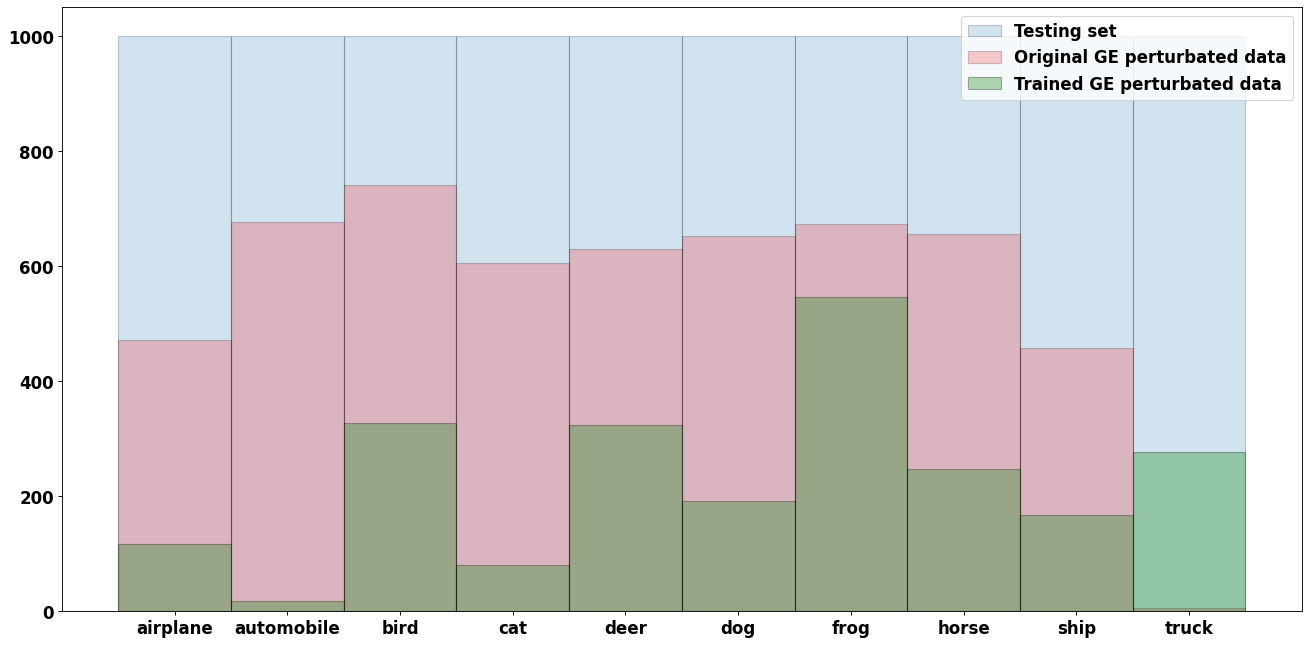

In [57]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

bins = np.arange(11) - 0.5
figure(figsize=(20, 10), dpi=80)
plt.hist(ori_label,bins,alpha=0.2,edgecolor='black',label='Testing set')
plt.hist(all_ori_class_pre,bins,edgecolor='black',alpha=0.2,color='red',label='Original GE perturbated data')

bins = np.arange(11) - 0.5
plt.hist(all_ori_class_post,bins,edgecolor='black',color='green',alpha=0.3,label='Trained GE perturbated data')
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels=cifar_class)

plt.legend()